In [1]:
# %pip install nltk
# %pip install numpy
# %pip install spacy
# %pip install pandas
# %pip install sklearn
# %pip install matplotlib
# %pip install tensorflow
# %pip install locationtagger
# %python -m spacy download en_core_web_sm

In [2]:
from preprocess import Custom_Preprocessor
from location_extractor import get_locations, get_states_list

import os
import pickle
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding, Bidirectional, SpatialDropout1D

In [3]:
# import nltk
# import spacy
# nltk.downloader.download('maxent_ne_chunker')
# nltk.downloader.download('words')
# nltk.downloader.download('treebank')
# nltk.downloader.download('maxent_treebank_pos_tagger')
# nltk.downloader.download('punkt')
# nltk.download('averaged_perceptron_tagger')

In [4]:
train_df = pd.read_excel("..\Category Data\crime_type_data.xlsx")
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49317 entries, 0 to 49316
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Title   49317 non-null  object
 1   Type    49317 non-null  object
dtypes: object(2)
memory usage: 770.7+ KB
None


In [5]:
print(train_df.describe())

print(f"All entries unique: {train_df['Title'].nunique()==train_df.shape[0]}")
print(f"Null cells: {train_df.isnull().sum().sum()}")

                                                    Title    Type
count                                               49317   49317
unique                                              48629       4
top     #Bulandshahr: Class 12 girl kidnapped, raped a...  Murder
freq                                                    4   29467
All entries unique: False
Null cells: 0


In [6]:
train_df.drop_duplicates(subset=['Title'], inplace=True, ignore_index=True, keep='first')

print(f"All entries unique: {train_df['Title'].nunique()==train_df.shape[0]}")
print(f"Null cells: {train_df.isnull().sum().sum()}")

All entries unique: True
Null cells: 0


In [7]:
Preprocessor = Custom_Preprocessor()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sgfri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
filtered_df = pd.DataFrame(columns=['text', 'label', 'word_count', 'label_name', 'location'])

filtered_df['label_name'] = pd.Series(pd.Categorical(train_df['Type']))
filtered_df['label'] = (pd.Categorical(filtered_df['label_name']).codes).astype(int)
label_ids = dict(enumerate(filtered_df['label_name'].cat.categories))

print("Label IDs")
print(label_ids)

filtered_df['text'], filtered_df['word_count'] = Preprocessor.preprocess_data_x(train_df['Title'], get_word_count=True)
filtered_df = filtered_df[filtered_df['word_count']>2]
filtered_df.reset_index(inplace=True)
filtered_df['location']=get_locations(filtered_df['text'], get_state_of_cities=True)

print(filtered_df.head())

Label IDs
{0: 'Kidnap', 1: 'Murder', 2: 'Rape', 3: 'Theft'}
   index                                               text  label  \
0      0  delhi heinous crimes per cent cases reported t...      0   
1      1  missing teenager found dead family attacks pol...      0   
2      2  indian american man fails bring kid back us co...      0   
3      3  kidnapping case rubaiya sayeed mehbooba mufti ...      0   
4      4  bihar veterinary called check animal kidnapped...      0   

   word_count label_name         location  
0           9     Kidnap   [nct of delhi]  
1           9     Kidnap  [uttar pradesh]  
2          12     Kidnap             None  
3          12     Kidnap             None  
4           8     Kidnap          [bihar]  


In [9]:
for i in range(len(filtered_df.head())):
    print(f'Text: {train_df.loc[i, "Title"]}\nLocation: {filtered_df.loc[i, "location"]}')

Text: Delhi: Heinous crimes up over 13 per cent, 3,140 cases reported till July 2022
Location: ['nct of delhi']
Text: Missing teenager found dead, family attacks police team in UP's Badaun
Location: ['uttar pradesh']
Text: Indian-American man fails to bring kid back to US, convicted of international parental kidnapping
Location: None
Text: 1989 kidnapping case: Rubaiya Sayeed, Mehbooba Mufti's sister identifies Yasin Malik among 4 accused
Location: None
Text: Bihar: Veterinary called to check on animal, kidnapped and married off forcibly
Location: ['bihar']


In [10]:
api_df_columns = list(label_ids.values())+['Total']
states = get_states_list()
state_map = {key.lower(): key for key in states}
sec_dict = {key: 0 for key in api_df_columns}
api_dict = {key: sec_dict.copy() for key in states}

for i in range(len(filtered_df)):
    if filtered_df.loc[i, 'location'] is not None:
        category = filtered_df.loc[i,'label_name']
        for location in filtered_df.loc[i, 'location']:
            api_dict[state_map[location]][category] +=1
            api_dict[state_map[location]]['Total'] +=1

api_df = pd.DataFrame.from_dict(api_dict, orient='index')

In [11]:
filtered_df.to_excel("..\Category Data\crime_type_data_filtered.xlsx", index=False)
api_df.to_excel("..\Category Data/api_data_processed.xlsx")

Murder    29411
Rape      10353
Theft      4524
Kidnap     4341
Name: Type, dtype: int64


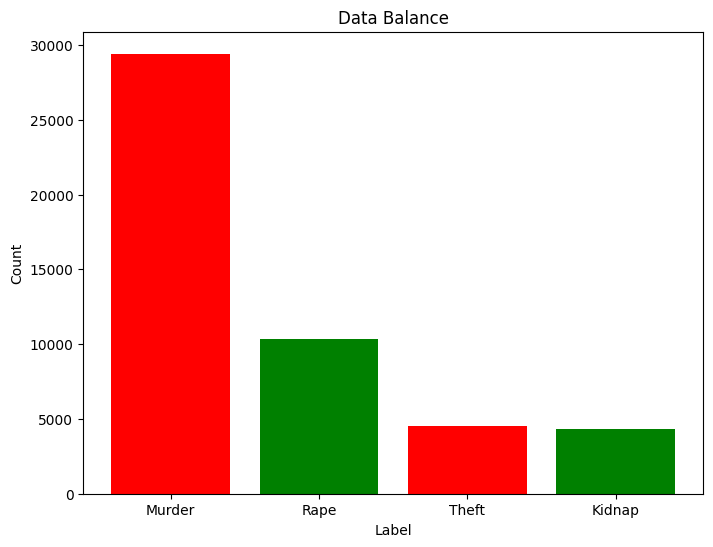

Average Word count: 14.800123418697932
        Max Word Count: 47
        Min Word Count: 3


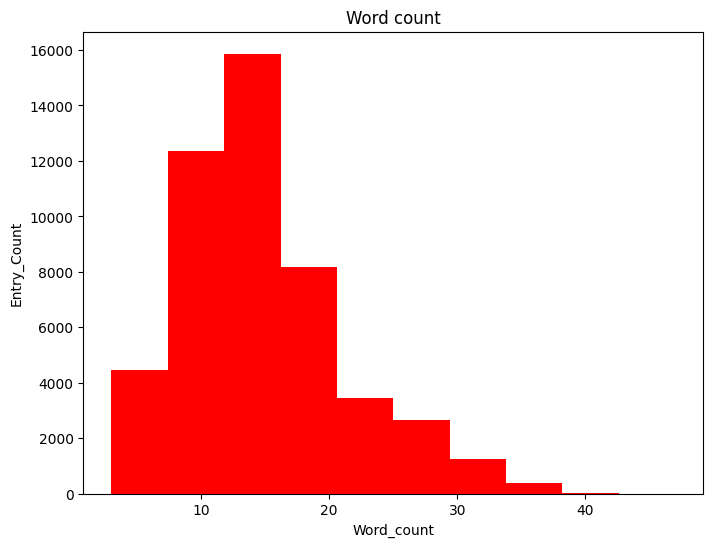

In [12]:
label_counts = train_df['Type'].value_counts()
print(label_counts)

plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts, color=['red', 'green'])
plt.ylabel('Count')
plt.xlabel('Label')
plt.title('Data Balance')
plt.show()

print(f'Average Word count: {np.average(filtered_df["word_count"])}\n\
        Max Word Count: {max(filtered_df["word_count"])}\n\
        Min Word Count: {min(filtered_df["word_count"])}')

plt.figure(figsize=(8, 6))
plt.hist(filtered_df['word_count'],color='red')
plt.title('Word count')
plt.xlabel('Word_count')
plt.ylabel('Entry_Count')
plt.show()

In [13]:
MAX_NB_WORDS = 75000
MAX_SEQUENCE_LENGTH = max(filtered_df["word_count"])
EMBEDDING_DIM = 10
OOV_TOK= '<OOV>'

TEST_SIZE = 0.4
VALIDATION_SIZE = 0.2
LR = 0.000075
DECAY = 1e-6
NUM_EPOCH = 500
BATCH_SIZE = 150
MIN_CONFIDENCE = 0.65

In [14]:
Preprocessor.set_max_seq_length(MAX_SEQUENCE_LENGTH)

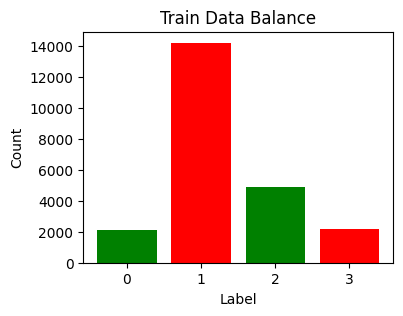

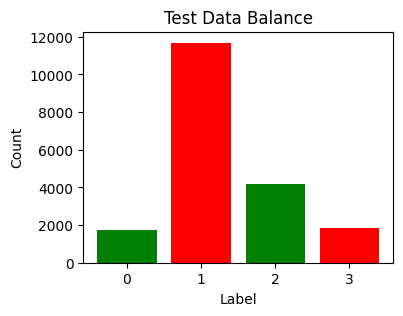

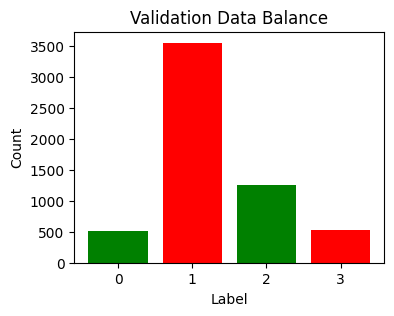

In [15]:
x_train_val,x_test,y_train_val,y_test = train_test_split(filtered_df['text'], filtered_df['label'], test_size=TEST_SIZE,shuffle=True)
x_train,x_val,y_train,y_val = train_test_split(x_train_val, y_train_val, test_size=VALIDATION_SIZE,shuffle=True)

train_label_counts = y_train.value_counts()
test_label_counts = y_test.value_counts()
val_label_counts = y_val.value_counts()

plt.figure(figsize=(4, 3))
plt.bar(train_label_counts.index, train_label_counts, color=['red', 'green'])
plt.ylabel('Count')
plt.xlabel('Label')
plt.title('Train Data Balance')
plt.show()
plt.figure(figsize=(4, 3))
plt.bar(test_label_counts.index, test_label_counts, color=['red', 'green'])
plt.ylabel('Count')
plt.xlabel('Label')
plt.title('Test Data Balance')
plt.show()
plt.figure(figsize=(4, 3))
plt.bar(val_label_counts.index, val_label_counts, color=['red', 'green'])
plt.ylabel('Count')
plt.xlabel('Label')
plt.title('Validation Data Balance')
plt.show()

In [16]:
tokenizer = Tokenizer(num_words = MAX_NB_WORDS, oov_token=OOV_TOK)
tokenizer.fit_on_texts(filtered_df['text'])
print(f'Total Entries/Tweets: {len(filtered_df)}\n\
        Total Tokens: {len(tokenizer.word_index)}\n\
        Token Limit: {MAX_NB_WORDS}')

x_train_padded = Preprocessor.tokenise(tokenizer, x_train)
x_test_padded = Preprocessor.tokenise(tokenizer, x_test)
x_val_padded = Preprocessor.tokenise(tokenizer, x_val)

Total Entries/Tweets: 48615
        Total Tokens: 72306
        Token Limit: 75000


In [17]:
model = Sequential()

model.add(Embedding(MAX_NB_WORDS,EMBEDDING_DIM))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(EMBEDDING_DIM)))
model.add(Dense(4,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 10)          750000    
                                                                 
 spatial_dropout1d (SpatialD  (None, None, 10)         0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 20)               1680      
 l)                                                              
                                                                 
 dense (Dense)               (None, 4)                 84        
                                                                 
Total params: 751,764
Trainable params: 751,764
Non-trainable params: 0
_________________________________________________________________


In [72]:
optimizer = Adam(learning_rate=LR, weight_decay=DECAY)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'],
)

earlystopping = EarlyStopping(monitor='val_accuracy', patience=35, min_delta=0.0001, restore_best_weights=True)

history = model.fit(
    x_train_padded, y_train,
    epochs=NUM_EPOCH,
    # validation_split=0.1,
    validation_data=(x_val_padded, y_val),
    callbacks=[earlystopping],
    batch_size=BATCH_SIZE,
    verbose=2)

Epoch 1/500
156/156 - 7s - loss: 1.3529 - accuracy: 0.5835 - val_loss: 1.3137 - val_accuracy: 0.6003 - 7s/epoch - 44ms/step
Epoch 2/500
156/156 - 4s - loss: 1.2387 - accuracy: 0.6028 - val_loss: 1.1493 - val_accuracy: 0.6003 - 4s/epoch - 25ms/step
Epoch 3/500
156/156 - 4s - loss: 1.0899 - accuracy: 0.6028 - val_loss: 1.0748 - val_accuracy: 0.6003 - 4s/epoch - 26ms/step
Epoch 4/500
156/156 - 4s - loss: 1.0597 - accuracy: 0.6028 - val_loss: 1.0606 - val_accuracy: 0.6003 - 4s/epoch - 27ms/step
Epoch 5/500
156/156 - 4s - loss: 1.0421 - accuracy: 0.6028 - val_loss: 1.0385 - val_accuracy: 0.6003 - 4s/epoch - 25ms/step
Epoch 6/500
156/156 - 4s - loss: 1.0099 - accuracy: 0.6028 - val_loss: 0.9934 - val_accuracy: 0.6003 - 4s/epoch - 25ms/step
Epoch 7/500
156/156 - 4s - loss: 0.9526 - accuracy: 0.6028 - val_loss: 0.9235 - val_accuracy: 0.6003 - 4s/epoch - 26ms/step
Epoch 8/500
156/156 - 4s - loss: 0.8919 - accuracy: 0.6038 - val_loss: 0.8711 - val_accuracy: 0.6035 - 4s/epoch - 27ms/step
Epoch 9/

In [73]:
accr = model.evaluate(x_test_padded,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

608/608 [==============================] - 2s 3ms/step - loss: 0.5626 - accuracy: 0.8406
Test set
  Loss: 0.563
  Accuracy: 0.841


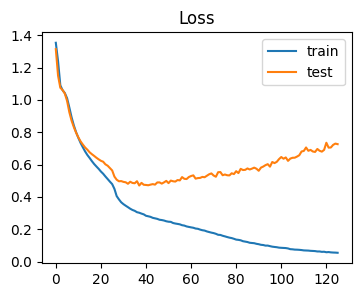

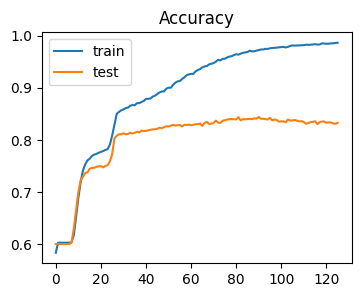

In [74]:
plt.figure(figsize=(4, 3))
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()
plt.figure(figsize=(4, 3))
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [18]:
new_complaints = [
    "Government makes GST compulsory", 
    "Aviral commited theft by stealing my pen",
    "Kartik stabbed his roommate out of spite",
    "Kidnapping caught on camera, attempt made to abduct child"
    ]

pre_complaints = Preprocessor.preprocess_data_x(new_complaints)
padded = Preprocessor.tokenise(tokenizer, pre_complaints)
pred_list = model.predict(padded)

for i in range(len(pred_list)):
    print(new_complaints[i])
    print(pre_complaints[i])
    print(padded[i])
    max_con = np.max(pred_list[i])
    print(pred_list[i])
    if max_con >= MIN_CONFIDENCE:
        print(f'{label_ids[np.argmax(pred_list[i])]}: {max_con*100:.2f} % confidence')
    else:
        print('Possible Non-Crime')

1/1 [==============================] - 1s 659ms/step
Government makes GST compulsory
government makes gst compulsory
[ 227 1840 9282    1    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0]
[0.24790019 0.26048088 0.24289383 0.2487251 ]
Possible Non-Crime
Aviral commited theft by stealing my pen
aviral commited theft stealing pen
[   1    1  251  598 9247    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0]
[0.24911541 0.25709945 0.24445519 0.24933001]
Possible Non-Crime
Kartik stabbed his roommate out of spite
kartik stabbed roommate spite
[7728   45 4420 9624    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0

In [76]:
# dir_path = f"./Weights/{accr[0]*100:.2f}_{accr[1]*100:.2f}"

# if not os.path.isdir(dir_path):
#     os.makedirs(dir_path)

# with open(dir_path+'/tokenizer.pickle', 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# model.save(dir_path+'/model')
# # with open('tokenizer.pickle', 'rb') as handle:
# #     tokenizer = pickle.load(handle)